https://www.katnoria.com/mdn/

TF 2.0 example

In [129]:
# Add required imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

In [130]:
# Example presented in the PRML book
def create_book_example(n=1000):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,1)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,1)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)    
    return X, y, x_test

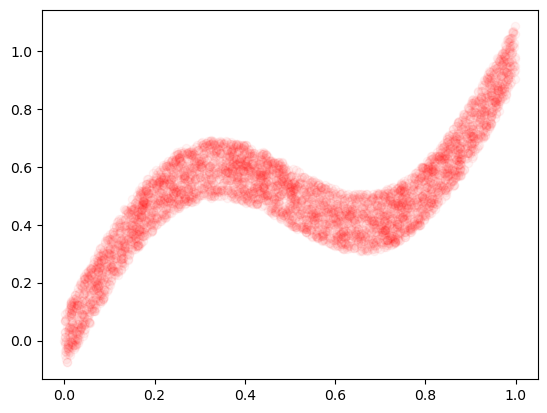

In [131]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=4000)
plt.plot(X, y, 'ro', alpha=0.04)
plt.show()

In [132]:
# Load Tensorflow
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from copy import deepcopy

In [133]:
tf.__version__

'2.16.1'

In [134]:
# Is GPU Available
tf.config.list_physical_devices('GPU')

[]

In [135]:
tf.executing_eagerly()

True

## Inverse problem



In [136]:
# print data shape
print(X.shape, y.shape)

# Deepcopy is not required in this case
# (its more of a habit for me)
flipped_x = deepcopy(y)
flipped_y = deepcopy(X)

(4000, 1) (4000, 1)


## Mixture density network

In MDNs, instead of modeling the input (x) -> target (y) mapping by explicitly generating the output values, we learn the probability distribution of each target and sample the predicted output $\hat{y}$ from that distribution. The distribution itself is represented by several gaussians (i.e a mixture of gaussians). A mixture of gaussians is able to represent a complex distribution as shown in the plot titled ‘Multimodal distribution’ at the begining of this post.

For every input x, we learn the distribution parameters namely mean, variance and mixing coefficient. In terms of total output values, there are $(l+2)k$ values where $k$ is the number of gaussians and $l$ is the number of input features. The breakdown of output values is shown below:

- Mixing coefficient ($\pi$): $k$
- Variance ($\sigma^2$): $k$
- Mean ($\mu$): $l \times k$

MDN provides a generic framework for modeling conditional probability distribution using a linear combination of mixing coefficient and respective component densities:

$$
p(y|x) = \sum_k \pi_k(x) \mathcal{N} (y|\mu_k(x), \sigma^2_k(x))
$$

In [137]:
# In our toy example, we have single input feature
l = 1
# Number of gaussians to represent the multimodal distribution
k = 26

# Network
input = tf.keras.Input(shape=(l,))
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)
mu = tf.keras.layers.Dense((l * k), activation=None, name='mean_layer')(layer)
# variance (should be greater than 0 so we exponentiate it)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
# mixing coefficient should sum to 1.0
pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)

In [138]:
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baselayer (Dense)   │ (None, 50)        │        100 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_var_layer     │ (None, 26)        │      1,326 │ baselayer[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi_layer (Dense)    │ (None, 26)        │      1,326 │ baselayer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_layer (Dense)  │ (None, 26)        │      1,326 │ baselayer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variance_layer      │ (None, 26)        │          0 │ dense_var_layer[… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,078 (15.93 KB)

 Trainable params: 4,078 (15.93 KB)

 Non-trainable params: 0 (0.00 B)

The loss function with respect to component weights w is given by

$$
L(w) = \frac{-1}{N} \sum_{n=1}^N log(\sum_k \pi_k(x_n, w)\mathcal{N}(y_n|\mu_k(x_n,w),\sigma^2(x_n,w)))
$$

The component density is given by

$$
f(x) = \frac{e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2 \pi \sigma^2}}
$$

In [139]:
# Take a note how easy it is to write the loss function in 
# new tensorflow eager mode (debugging the function becomes intuitive too)

def calc_pdf(y, mu, var):
    """Calculate component density"""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value


def mdn_loss(y_true, pi, mu, var):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
    out = calc_pdf(y_true, mu, var)
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

Lets verify whether our implementation is correct by comparing the values with numpy version

In [140]:
calc_pdf(np.array([3.0]), np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3])).numpy()

array([0.00443185, 0.03977444, 0.06695205])

In [141]:
# Numpy version
def pdf_np(y, mu, var):
    n = np.exp((-(y-mu)**2)/(2*var))
    d = np.sqrt(2 * np.pi * var)
    return n/d
print('Numpy version: ')
pdf_np(3.0, np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3]))

Numpy version: 


array([0.00443185, 0.03977444, 0.06695205])

In [142]:
loss_value = mdn_loss(
    np.array([3.0, 1.1]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]).reshape(2,-1).astype('float64'), 
    np.array([[0.0, 0.1, 0.2], [0.0, 0.1, 0.2]]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 2.2, 3.3], [1.0, 2.2, 3.3]]).reshape(2,-1).astype('float64')
).numpy()

assert np.isclose(loss_value, 3.4714, atol=1e-5), 'MDN loss incorrect'

In [143]:
# Use Dataset API to load numpy data (load, shuffle, set batch size)
N = flipped_x.shape[0]
N = 1000
dataset = tf.data.Dataset \
    .from_tensor_slices((flipped_x, flipped_y)) \
    .shuffle(N).batch(N)

In [144]:
@tf.function
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [145]:
# Define model and optimizer
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
for tx, ty in dataset:
    print("1")
    #print(tx)
    #print(ty)
    loss = train_step(model, optimizer, tx, ty)
    print(f"tmp {loss}")

print(loss)

1
tmp 1.1018288135528564
1
tmp 1.0953352451324463
1
tmp 1.0843911170959473
1
tmp 1.086543321609497
tf.Tensor(1.0865433, shape=(), dtype=float32)


2025-01-22 18:21:05.373007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [77]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [18]:
ty

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[0.83127564],
       [0.8132008 ],
       [0.17782666],
       ...,
       [0.7013426 ],
       [0.76221913],
       [0.5458555 ]], dtype=float32)>

In [65]:
losses = []
EPOCHS = 6000
print_every = int(0.1 * EPOCHS)

# Define model and optimizer
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))  

Print every 600 epochs


2025-01-21 09:25:43.825445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.832377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.839230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.845186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.852709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.859494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:43.866309: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 0/6000: loss 1.0916765928268433


2025-01-21 09:25:44.031078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.037422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.043736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.052515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.059085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.065354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:44.071234: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 600/6000: loss -0.8162314295768738


2025-01-21 09:25:48.130728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.137628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.144557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.151792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.158458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.165467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:48.172292: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1200/6000: loss -0.9634162783622742


2025-01-21 09:25:52.450874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.457883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.465204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.471991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.479176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.486278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:52.493035: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1800/6000: loss -0.9893009662628174


2025-01-21 09:25:56.745297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.752368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.759381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.766221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.772843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.780079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:25:56.786712: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 2400/6000: loss -1.0036579370498657


2025-01-21 09:26:01.038590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.046075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.053789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.061430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.068475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.075691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:01.082848: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 3000/6000: loss -1.0128248929977417


2025-01-21 09:26:05.545982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.553331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.560242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.566985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.574209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.580918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:05.588062: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 3600/6000: loss -1.017795443534851


2025-01-21 09:26:09.838510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.846447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.854453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.862607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.870762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.878712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:09.886583: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 4200/6000: loss -1.0233850479125977


2025-01-21 09:26:14.356483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.364048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.371391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.378135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.385382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.392159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:14.398984: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 4800/6000: loss -1.0301177501678467


2025-01-21 09:26:18.659996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.670057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.692180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.703362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.710401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.717352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:18.724523: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 5400/6000: loss -1.0357388257980347


2025-01-21 09:26:22.937283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.944274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.951258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.958411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.965211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.972148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-21 09:26:22.978806: W tensorflow/core/framework/local_rendezvous.cc:404] L

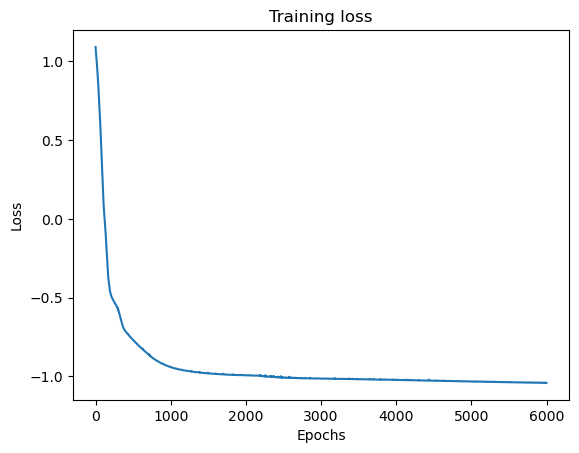

In [66]:
# Let's plot the training loss
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


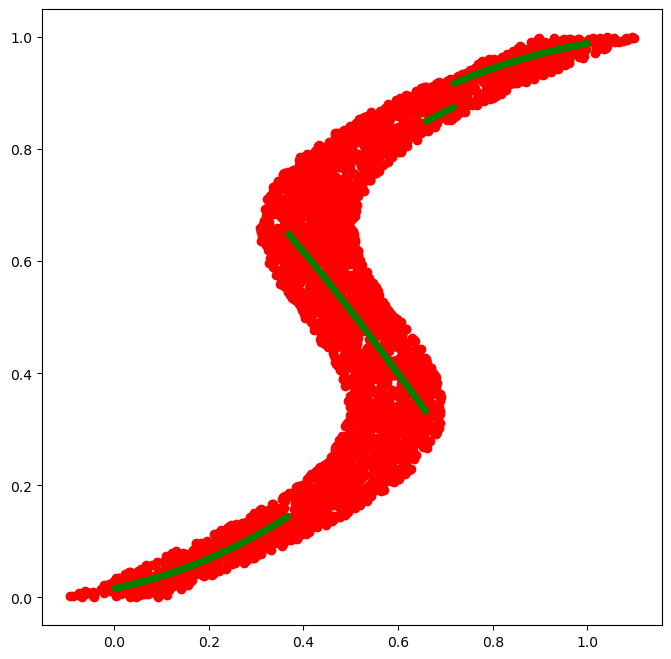

In [67]:
def approx_conditional_mode(pi, var, mu):
    """Approx conditional mode
    Because the conditional mode for MDN does not have simple analytical
    solution, an alternative is to take mean of most probable component 
    at each value of x (PRML, page 277)
    """
    n, k = pi.shape
    out = np.zeros((n, l))
    # Get the index of max pi value for each row
    max_component = tf.argmax(pi, axis=1)
    for i in range(n):
        # The mean value for this index will be used
        mc = max_component[i].numpy()
        for j in range(l):
            out[i, j] = mu[i, mc*(l+j)]
    return out


# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)
pi_vals.shape, mu_vals.shape, var_vals.shape

# Get mean of max(mixing coefficient) of each row
preds = approx_conditional_mode(pi_vals, var_vals, mu_vals)

# Plot along with training data
fig = plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro')
plt.plot(x_test, preds, 'g.')
# plt.plot(flipped_x, preds2, 'b.')
plt.show()

In [68]:
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 10)

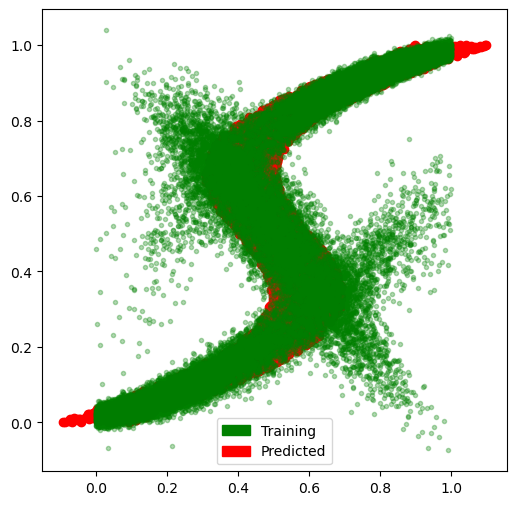

In [69]:
# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(x_test, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]

plt.legend(handles=patches)
plt.show()

In [70]:
pi_vals.shape

(4000, 26)

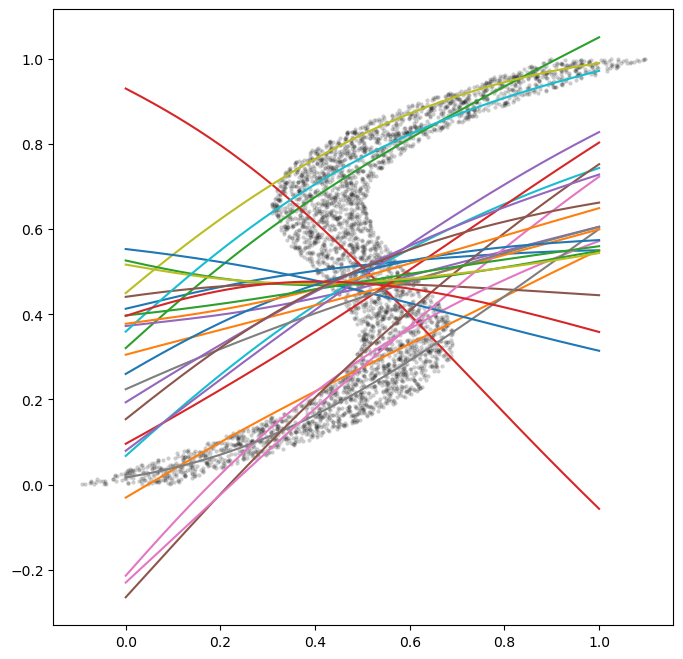

In [71]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_vals.T, var_vals.T):
    plt.plot(x_test, mu_k)
    # plt.fill_between(x_test, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(flipped_x, flipped_y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()

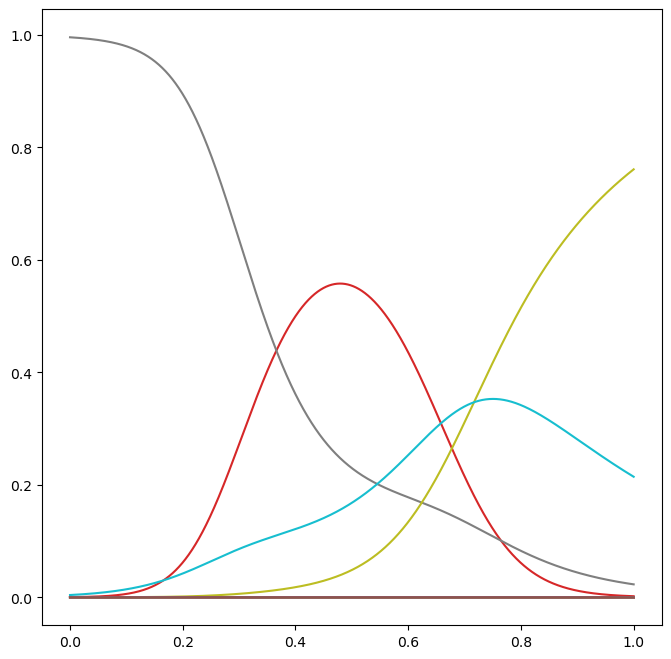

In [72]:
plt.figure(figsize=(8, 8), facecolor='white')
for pi_k, sigma_k in zip(pi_vals.T, var_vals.T):
    plt.plot(x_test, pi_k)
    # plt.fill_between(x_test, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
# plt.scatter(flipped_x, flipped_y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()